# IEMS 469 : Reinforcement Learning Homework 2 -- Policy Gradient

This notebook contains a simple **pytorch** implementation of the **Actor-Critic** method. We train two separate neural networks: **Actor** and **Critic**.

1. **Actor** updates the policy distribution in the direction suggested by **Critic** 
2. **Critic** estimates the value function.

## Part a)

In this section, we apply the Actor-Critic method on the Atari Game **CartPole-v0**. Both **Actor** and **Critic** are simple two-layer neural network with ReLU activation function.

In [1]:
import gym, os
from itertools import count
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import argparse
import numpy as np
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v0").unwrapped

C:\Users\Home\anaconda3\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


For the **CartPoe-v0** game, the state space contains four elements and there are two candidate actions.

In [2]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

Build the **Actor** and **Critic** networks using **pytorch**

In [3]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = nn.Linear(self.state_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        value = self.linear3(output)
        return value

`compute_returns()` computes the accumulative rewards from the terminal step.

In [4]:
def compute_returns(next_value, rewards, masks, gamma=0.95):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

Main training loop

In [5]:
actor = Actor(state_size, action_size).to(device)
critic = Critic(state_size, action_size).to(device)
epochs = 300

optimizerA = optim.Adam(actor.parameters())
optimizerC = optim.Adam(critic.parameters())
# a array to store the total reward per iteration
score = []
for i_epoch in range(epochs):
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    masks = []
    env.reset()
    #training epochs 
    for i in count():
        env.render()
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)

        action = dist.sample()
        next_state, reward, done, _ = env.step(action.cpu().numpy())

        log_prob = dist.log_prob(action).unsqueeze(0)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

        state = next_state

        if done:
            print('Actor Critic ep %06d done. reward: %f' % (i_epoch, i))
            score.append(i)
            break


    next_state = torch.FloatTensor(next_state).to(device)
    next_value = critic(next_state)
    returns = compute_returns(next_value, rewards, masks)

    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)

    advantage = returns - values

    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizerA.step()
    optimizerC.step()
env.close()


torch.save(actor, 'actor_cartpolev0.pkl')
torch.save(critic, 'critic_cartpolev0.pkl')


Actor Critic ep 000000 done. reward: 12.000000
Actor Critic ep 000001 done. reward: 14.000000
Actor Critic ep 000002 done. reward: 10.000000
Actor Critic ep 000003 done. reward: 11.000000
Actor Critic ep 000004 done. reward: 14.000000
Actor Critic ep 000005 done. reward: 17.000000
Actor Critic ep 000006 done. reward: 26.000000
Actor Critic ep 000007 done. reward: 25.000000
Actor Critic ep 000008 done. reward: 18.000000
Actor Critic ep 000009 done. reward: 19.000000
Actor Critic ep 000010 done. reward: 36.000000
Actor Critic ep 000011 done. reward: 27.000000
Actor Critic ep 000012 done. reward: 16.000000
Actor Critic ep 000013 done. reward: 23.000000
Actor Critic ep 000014 done. reward: 22.000000
Actor Critic ep 000015 done. reward: 25.000000
Actor Critic ep 000016 done. reward: 19.000000
Actor Critic ep 000017 done. reward: 27.000000
Actor Critic ep 000018 done. reward: 16.000000
Actor Critic ep 000019 done. reward: 17.000000
Actor Critic ep 000020 done. reward: 11.000000
Actor Critic 

FileNotFoundError: [Errno 2] No such file or directory: 'model/actor_cartpolev0.pkl'

## Plot total episode rewards versus training epochs

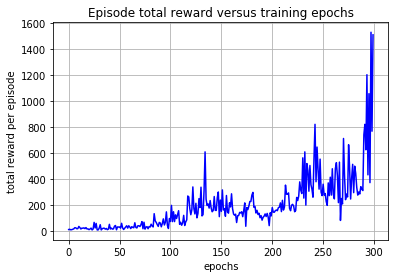

In [15]:
x = range(epochs)
plt.plot(x, score, 'b')
plt.xlabel('epochs')
plt.ylabel('total reward per episode')
plt.title('Episode total reward versus training epochs')
plt.grid()
plt.show()

## Part b) 

Applying the **Actor-Critic** learning method to the **Pong-v0** game. 

Some tuning parameters:

In [30]:
parser = argparse.ArgumentParser(description='PyTorch Policy Graident Actor Critic example at openai-gym pong')
parser.add_argument('--gamma', type=float, default=0.95, metavar='G',
                    help='discount factor (default: 0.99')
parser.add_argument('--decay_rate', type=float, default=0.99, metavar='G',
                    help='decay rate for RMSprop (default: 0.99)')
parser.add_argument('--learning_rate', type=float, default=1e-4, metavar='G',
                    help='learning rate (default: 1e-4)')
parser.add_argument('--seed', type=int, default=87, metavar='N',
                    help='random seed (default: 87)')
parser.add_argument('--test', action='store_true',
                    help='whether to test the trained model or keep training')
parser.add_argument('--max-grad-norm', type=float, default=1000)
args, unknown = parser.parse_known_args()

In [31]:
env = gym.make('Pong-v0')
env.seed(args.seed)
torch.manual_seed(args.seed)
D = 80 * 80

A preprocessing function that convert the $210 \times 160 \times 3$ photos into one-dimensional arrays

In [32]:
def prepro(I):
    """ prepro 210x160x3 into 6400 """
    I = I[35:195]
    I = I[::2, ::2, 0]
    I[I == 144] = 0
    I[I == 109] = 0
    I[I != 0] = 1
    return I.astype(np.float).ravel()

### Build two three-layer neural networks for **Actor** and **Critic**

In [33]:
class Actor(nn.Module):
    def __init__(self, num_actions=2):
        super(Actor, self).__init__()
        self.affine1 = nn.Linear(6400, 256)
        self.affine2 = nn.Linear(256, 512)
        self.affine3 = nn.Linear(512, num_actions)  
        self.num_actions = num_actions
        

    def forward(self, x):
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))
        action_scores = self.affine3(x)
        output = F.softmax(action_scores, dim=-1)
        distribution = Categorical(output)
        return distribution

class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.affine1 = nn.Linear(self.state_size, 256)
        self.affine2 = nn.Linear(256, 512)
        self.affine3 = nn.Linear(512, 1)

    def forward(self, state):
        output = F.relu(self.affine1(state))
        output = F.relu(self.affine2(output))
        value = self.affine3(output)
        return value

### Main loop

In [34]:
state_size = D
action_size = 2

# built policy network
actor = Actor().to(device)
# built value network
critic = Critic(state_size).to(device)


# assign optimizer
optimizerA = optim.RMSprop(actor.parameters(), lr=args.learning_rate, weight_decay=args.decay_rate)
optimizerC = optim.RMSprop(critic.parameters(), lr=args.learning_rate, weight_decay=args.decay_rate)

epochs = 400
# Main loop
reward_sum = 0
log_probs = []
values = []
masks = []
score = []
for i_epoch in range(epochs):
    reward_sum = 0
    state = env.reset()
    log_probs = []
    values = []
    rewards = []
    masks = []
    env.reset()
    prev_state = None
    for i in count():
        env.render()
        cur_state = prepro(state)
        state = cur_state - prev_state if prev_state is not None else np.zeros(D)
        prev_state = cur_state
        state = torch.FloatTensor(state).to(device)
        dist, value = actor(state), critic(state)
        action = dist.sample()
        # only 2 and 3 count
        action_env = action + 2
        next_state, reward, done, _ = env.step(action_env)
        log_prob = dist.log_prob(action).unsqueeze(0)
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
        masks.append(torch.tensor([1-done], dtype=torch.float, device=device))
        reward_sum += reward
        state = next_state
        if done:
            print('Actor Critic ep %03d done. reward: %f' % (i_epoch, reward_sum))
            score.append(reward_sum)
            reward_sum = 0
            break

    # use policy gradient update model weights
    next_state = prepro(next_state)
    next_state = torch.FloatTensor(next_state).to(device)
    next_value = critic(next_state)
    returns = compute_returns(next_value, rewards, masks)
    
    log_probs = torch.cat(log_probs)
    returns = torch.cat(returns).detach()
    values = torch.cat(values)
    
    advantage = returns - values
    
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    
    optimizerA.zero_grad()
    optimizerC.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor.parameters(), args.max_grad_norm)  # gradient clip
    torch.nn.utils.clip_grad_norm_(critic.parameters(), args.max_grad_norm)  # gradient clip

    optimizerA.step()
    optimizerC.step()
    # Save model in every 50 episode
    if i_epoch % 100 == 0
        print('ep %d: model saving...' % (i_epoch))
        torch.save(actor, 'actor_pongv0.pkl')
        torch.save(critic, 'critic_pongv0.pkl')
env.close()

torch.save(actor, 'actor_pongv0.pkl')
torch.save(critic, 'critic_pongv0.pkl')

C:\Users\Home\anaconda3\lib\site-packages\gym\envs\atari\environment.py:257: UserWarning: WARN: We strongly suggest supplying `render_mode` when constructing your environment, e.g., gym.make(ID, render_mode='human'). Using `render_mode` provides access to proper scaling, audio support, and proper framerates.
  "We strongly suggest supplying `render_mode` when "


Actor Critic ep 000 done. reward: -20.000000
Actor Critic ep 001 done. reward: -20.000000
Actor Critic ep 002 done. reward: -20.000000
Actor Critic ep 003 done. reward: -19.000000
Actor Critic ep 004 done. reward: -21.000000
Actor Critic ep 005 done. reward: -19.000000
Actor Critic ep 006 done. reward: -20.000000
Actor Critic ep 007 done. reward: -21.000000
Actor Critic ep 008 done. reward: -21.000000
Actor Critic ep 009 done. reward: -20.000000
Actor Critic ep 010 done. reward: -20.000000
Actor Critic ep 011 done. reward: -21.000000
Actor Critic ep 012 done. reward: -21.000000
Actor Critic ep 013 done. reward: -21.000000
Actor Critic ep 014 done. reward: -19.000000
Actor Critic ep 015 done. reward: -20.000000
Actor Critic ep 016 done. reward: -21.000000
Actor Critic ep 017 done. reward: -21.000000
Actor Critic ep 018 done. reward: -20.000000
Actor Critic ep 019 done. reward: -21.000000
Actor Critic ep 020 done. reward: -21.000000
Actor Critic ep 021 done. reward: -21.000000
Actor Crit

## Plot episode total reward versus training epochs

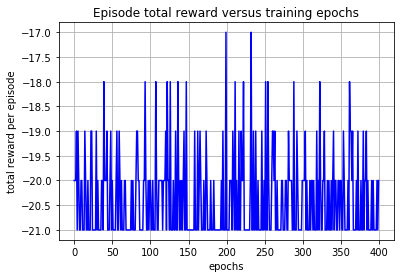

In [35]:
x = range(epochs)
plt.plot(x, score, 'b')
plt.xlabel('epochs')
plt.ylabel('total reward per episode')
plt.title('Episode total reward versus training epochs')
plt.grid()
plt.show()

# References

1. https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py
2. https://github.com/cuhkrlcourse/RLexample/blob/master/policygradient/ac-pong-pytorch.py